# Breast cancer circulating tumour cell classification

## 2.1. Random Forest


Importing necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import RocCurveDisplay, balanced_accuracy_score, PrecisionRecallDisplay, roc_auc_score, accuracy_score, make_scorer, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

pd.set_option('display.float_format', '{:.6f}'.format)

## Import CTC training and validation data

In [2]:
store = pd.HDFStore(os.path.join(os.pardir, 'data', 'ctc_split_datasets.h5'), mode='r')

X_train, X_valid = store["X_train"], store["X_valid"]
y_train, y_valid = store["y_train"], store["y_valid"]

store.close()
del store

View information about the data

In [3]:
X_train.info(), X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, BRx_42_1_10_20_CTC_jor to X245_CTC_mar
Columns: 52762 entries, ENSG00000223972.5 to ENSG00000210196.2
dtypes: float64(48523), int64(4239)
memory usage: 92.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, Brx116_1_SC1_092414_CTC_ebr to BRx_82_1_9_29_CTC_jor
Columns: 52762 entries, ENSG00000223972.5 to ENSG00000210196.2
dtypes: float64(48523), int64(4239)
memory usage: 16.1+ MB


(None, None)

In [4]:
y_train.info(), y_valid.info()

<class 'pandas.core.series.Series'>
Index: 230 entries, BRx_42_1_10_20_CTC_jor to X245_CTC_mar
Series name: state
Non-Null Count  Dtype
--------------  -----
230 non-null    int64
dtypes: int64(1)
memory usage: 3.6+ KB
<class 'pandas.core.series.Series'>
Index: 40 entries, Brx116_1_SC1_092414_CTC_ebr to BRx_82_1_9_29_CTC_jor
Series name: state
Non-Null Count  Dtype
--------------  -----
40 non-null     int64
dtypes: int64(1)
memory usage: 640.0+ bytes


(None, None)

## Class weights

Check class weights for EPI and MES to use them in model training process

In [9]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
print(class_weights)

[0.69277108 1.796875  ]


Check that the sum of the weights equals the number of samples (230)

In [10]:
class_0_weights_sum = class_weights[0]*y_train.value_counts()[0]
class_1_weights_sum = class_weights[1]*y_train.value_counts()[1]
class_0_weights_sum, class_1_weights_sum, class_0_weights_sum+class_1_weights_sum

(114.99999999999999, 115.0, 230.0)

### Results functions
Define functions to measure model training and validation results

In [11]:
"""
    Prints and displays metrics used to evaluate the model.
"""
def classifier_results(classifier_name:str, dataset_name:str, y, y_pred, y_pred_proba) -> None:    

    print(f"Mean accuracy ({dataset_name}):", accuracy_score(y, y_pred))
    print(f"Mean balanced accuracy({dataset_name}): ", balanced_accuracy_score(y, y_pred))
    print(f"Mean roc auc({dataset_name}): ", roc_auc_score(y, y_pred_proba))
    
    
    RocCurveDisplay.from_predictions(y, y_pred_proba, plot_chance_level=True, drop_intermediate=False)
    plt.title(f"{classifier_name} ROC Curve {dataset_name}")
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(y, y_pred_proba, plot_chance_level=True, drop_intermediate=False)
    plt.title(f"{classifier_name} Precision Recall Curve {dataset_name}")
    plt.show()
    
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"{classifier_name} Confusion Matrix {dataset_name}")
    plt.show()
    
    print(classification_report(y, y_pred))
    

"""
    Trains, validates and displays results of a DNN model with provided estimator(model).
"""
def rfc_classifier_results_from_estimator(rfc) -> None:
    y_train_pred = rfc.predict(X_train)
    y_train_pred_proba = rfc.predict_proba(X_train)[:,1]
    
    y_valid_pred = rfc.predict(X_valid)
    y_valid_pred_proba = rfc.predict_proba(X_valid)[:,1]
    
    classifier_results("Random Forest", "Training", y_train, y_train_pred, y_train_pred_proba)
    classifier_results("Random Forest", "Validation", y_valid, y_valid_pred, y_valid_pred_proba)
  

"""
    Creates, trains, validates and displays results of a DNN model with provided params.
    Returns the model.
""" 
def rfc_classifier_results(params) -> RandomForestClassifier:
    rfc = RandomForestClassifier(**params, n_jobs=-1)
    rfc.fit(X_train, y_train)
        
    
    y_train_pred = rfc.predict(X_train)
    y_train_pred_proba = rfc.predict_proba(X_train)[:,1]
    
    y_valid_pred = rfc.predict(X_valid)
    y_valid_pred_proba = rfc.predict_proba(X_valid)[:,1]
    
    classifier_results("Random Forest", "Training", y_train, y_train_pred, y_train_pred_proba)
    classifier_results("Random Forest", "Validation", y_valid, y_valid_pred, y_valid_pred_proba)
    
    return rfc

## Define functions using Random and Grid Search Cross-Validation

Define the parameters that divide the samples so that they are always drawn identically

In [12]:
random_state = 0
rng = np.random.RandomState(random_state)
cv_kFold = KFold(n_splits=7, shuffle=True, random_state=random_state)

Define functions to perform Random Search CV and Grid Search CV based on model parameters

In [14]:
"""
    Conducts random search for cross-validation on the training dataset with given parameters for search and model.
    Prints classification results for training and validation.
    Prints best params from grid search.
"""
def random_search_cv(classifier_params, search_params, n_iter=50, cv=cv_kFold):
    estimator = RandomForestClassifier(**classifier_params)
    random_search = RandomizedSearchCV(estimator=estimator,  param_distributions=search_params, n_iter=n_iter, cv=cv, verbose=3, n_jobs=-1, scoring={"balanced_accuracy": make_scorer(balanced_accuracy_score), "roc_auc":make_scorer(roc_auc_score),  "accuracy": make_scorer(accuracy_score)}, refit='balanced_accuracy', random_state=12)
    search_res = random_search.fit(X_train, y_train)
    print('_______________________________')
    rfc_classifier_results({**classifier_params, **search_res.best_params_})
    
    return search_res
    
"""
    Conducts grid search for cross-validation on the training dataset with given parameters for search and model.
    Prints classification results for training and validation.
    Prints best params from grid search.
"""
def grid_search_cv(classifier_params, search_params, cv=cv_kFold):
    estimator = RandomForestClassifier(**classifier_params)
    grid_search = GridSearchCV(estimator=estimator, param_grid=search_params,   cv=cv, verbose=3, n_jobs=-1,  scoring={"balanced_accuracy": make_scorer(balanced_accuracy_score), "roc_auc":make_scorer(roc_auc_score),  "accuracy": make_scorer(accuracy_score)}, refit='balanced_accuracy', )
    search_res = grid_search.fit(X_train, y_train)
    print('_______________________________')
    rfc_classifier_results_from_estimator(search_res.best_estimator_)
    
    return search_res

Define initial parameters for Random Forest that will be the same for all cross-validations

In [15]:
rfc_params = {
    'n_estimators': 5000,
    'bootstrap': True,
    'random_state': rng,
    'class_weight': 'balanced',
    'oob_score': True
}

## Find the best parameters for a model

### First attempt for Random CV

Fitting 7 folds for each of 15 candidates, totalling 105 fits
_______________________________
Mean accuracy (Training): 0.8304347826086956
Mean balanced accuracy(Training):  0.810523343373494
Mean roc auc(Training):  0.9330760542168675


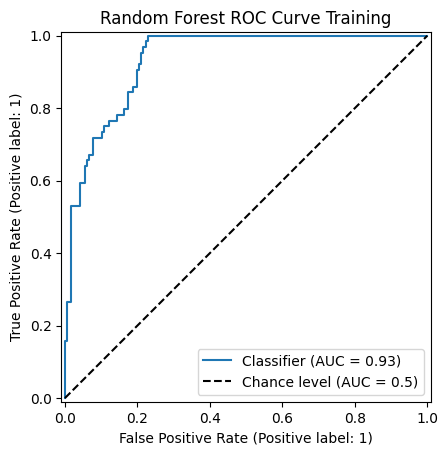

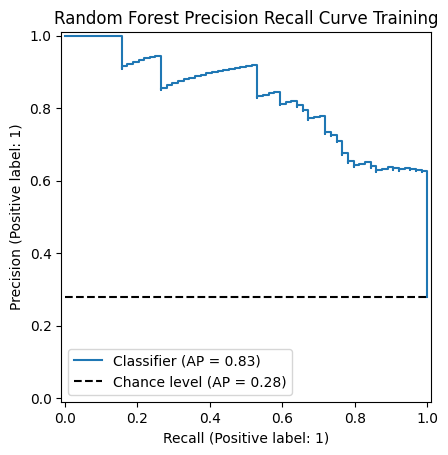

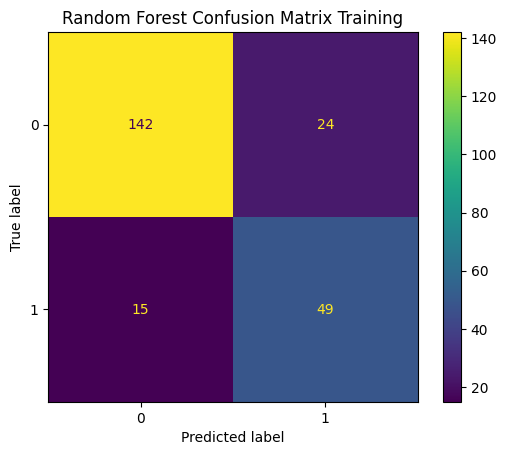

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       166
           1       0.67      0.77      0.72        64

    accuracy                           0.83       230
   macro avg       0.79      0.81      0.80       230
weighted avg       0.84      0.83      0.83       230

Mean accuracy (Validation): 0.9
Mean balanced accuracy(Validation):  0.8566308243727598
Mean roc auc(Validation):  0.9175627240143368


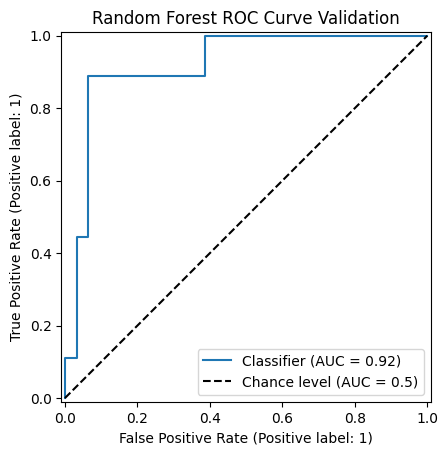

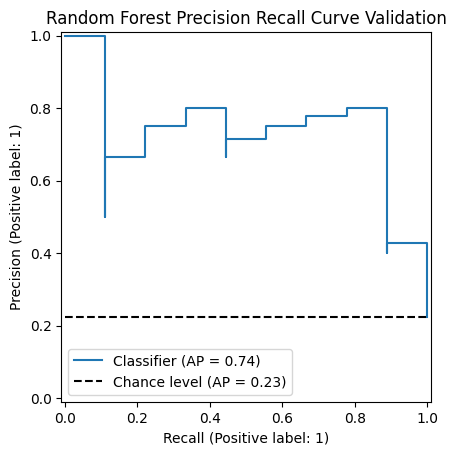

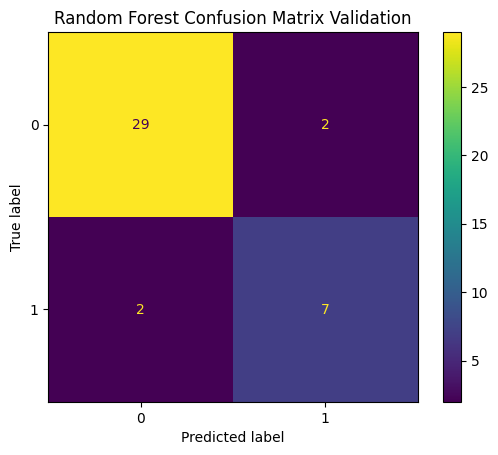

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.78      0.78      0.78         9

    accuracy                           0.90        40
   macro avg       0.86      0.86      0.86        40
weighted avg       0.90      0.90      0.90        40


{'min_weight_fraction_leaf': 0.01,
 'min_impurity_decrease': 0.15,
 'max_samples': 0.9,
 'max_leaf_nodes': None,
 'max_features': 0.25,
 'max_depth': 5,
 'criterion': 'log_loss'}

In [21]:
random_cv_params = {
    'criterion':['gini','entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20],
    'min_weight_fraction_leaf': [0.01, 0.03, 0.05, 0.07, 0.1], # weights sum = 230
    'min_impurity_decrease': [0.05, 0.1, 0.15],
    'max_features': ['sqrt', 0.1, 0.25, 0.5, 0.75],
    'max_samples': [0.25, 0.5, 0.75, 0.9],
    'max_leaf_nodes': [None, 10, 25, 50, 80],
}

random_cv_res = random_search_cv(rfc_params, random_cv_params, 15)
random_cv_res.best_params_

## Grid Search for each criterion function considering the parameters obtained from Random Search

### Grid Search for `gini` criterion function

Fitting 7 folds for each of 72 candidates, totalling 504 fits
_______________________________
Mean accuracy (Training): 0.8130434782608695
Mean balanced accuracy(Training):  0.7888742469879518
Mean roc auc(Training):  0.8951430722891567


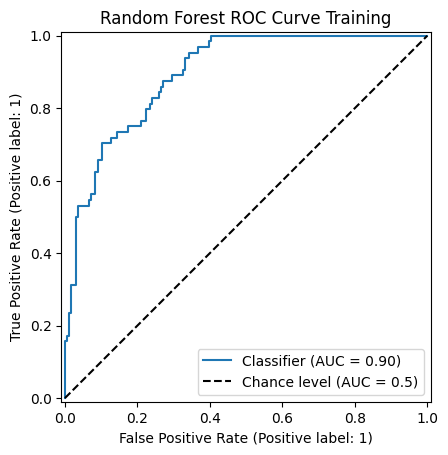

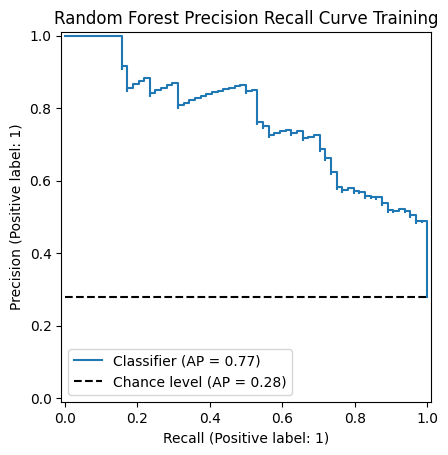

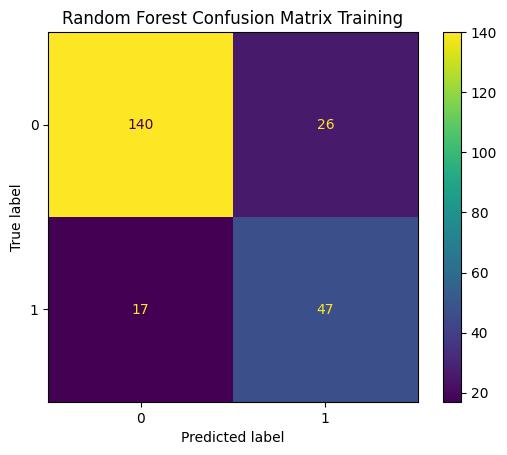

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       166
           1       0.64      0.73      0.69        64

    accuracy                           0.81       230
   macro avg       0.77      0.79      0.78       230
weighted avg       0.82      0.81      0.82       230

Mean accuracy (Validation): 0.875
Mean balanced accuracy(Validation):  0.8010752688172043
Mean roc auc(Validation):  0.8781362007168458


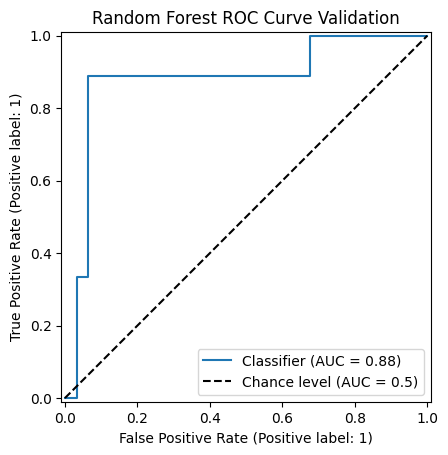

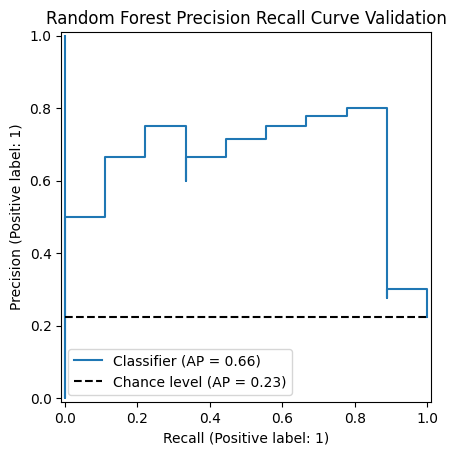

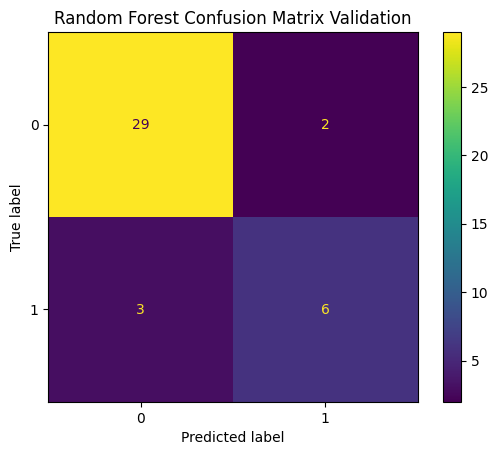

              precision    recall  f1-score   support

           0       0.91      0.94      0.92        31
           1       0.75      0.67      0.71         9

    accuracy                           0.88        40
   macro avg       0.83      0.80      0.81        40
weighted avg       0.87      0.88      0.87        40

{'criterion': 'gini', 'max_depth': 5, 'max_features': 0.25, 'max_leaf_nodes': None, 'max_samples': 0.9, 'min_impurity_decrease': 0.15, 'min_weight_fraction_leaf': 0.005}
out of bag score:  0.7782608695652173


In [50]:
grid_cv_params_gini = {
    'criterion':['gini'],
    'max_depth': [5, 10],
    'min_weight_fraction_leaf': [0.005, 0.01, 0.05], # weights sum = 230
    'min_impurity_decrease': [0.15],
    'max_features': ['sqrt', 'log2', 0.5, 0.25],
    'max_samples': [0.85, 0.9, 0.95],
    'max_leaf_nodes': [None],
}

grid_cv_res_gini = grid_search_cv(rfc_params, grid_cv_params_gini)
print(grid_cv_res_gini.best_params_)
print("out of bag score: ",grid_cv_res_gini.best_estimator_.oob_score_)

### Grid Search for `entropy` criterion function

Fitting 7 folds for each of 72 candidates, totalling 504 fits
_______________________________
Mean accuracy (Training): 0.8347826086956521
Mean balanced accuracy(Training):  0.8135353915662651
Mean roc auc(Training):  0.9320406626506024


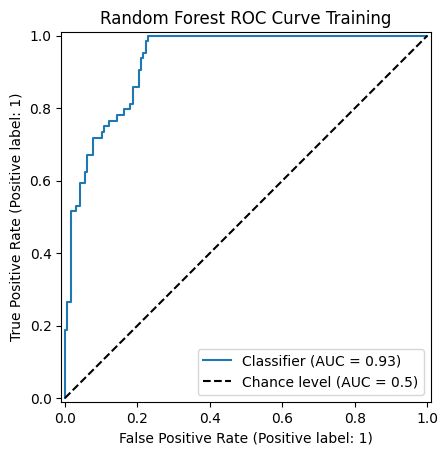

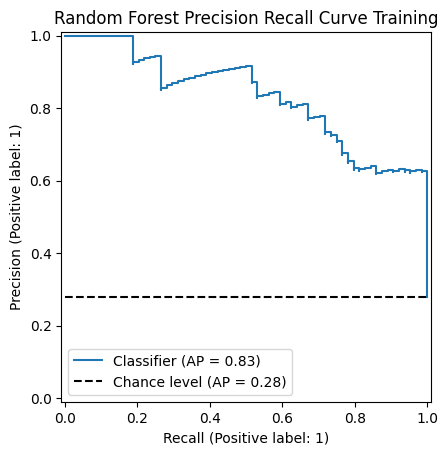

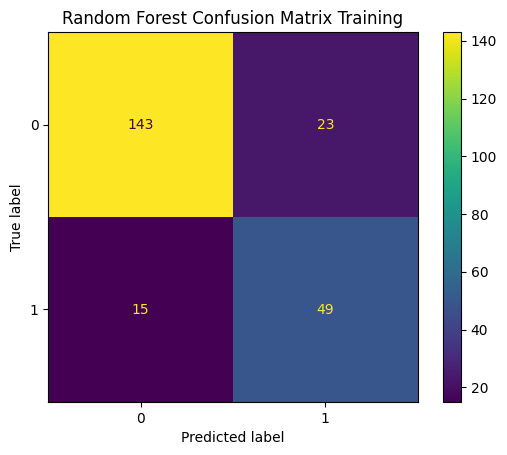

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       166
           1       0.68      0.77      0.72        64

    accuracy                           0.83       230
   macro avg       0.79      0.81      0.80       230
weighted avg       0.84      0.83      0.84       230

Mean accuracy (Validation): 0.9
Mean balanced accuracy(Validation):  0.8566308243727598
Mean roc auc(Validation):  0.9175627240143368


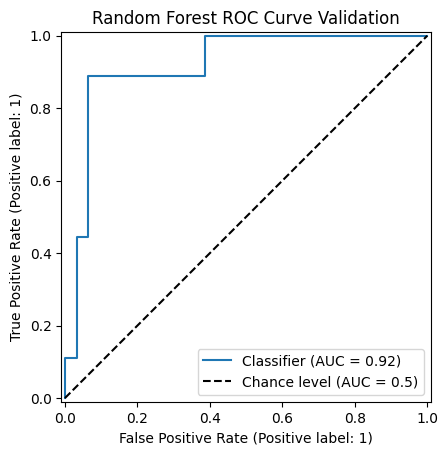

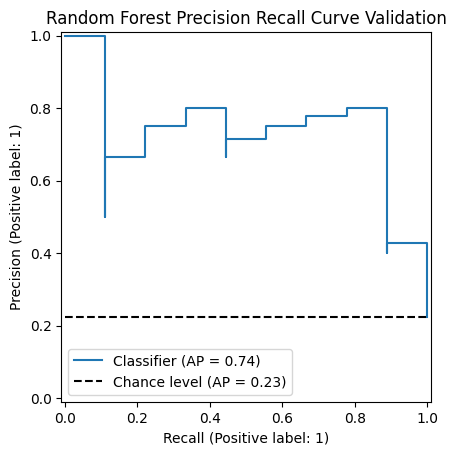

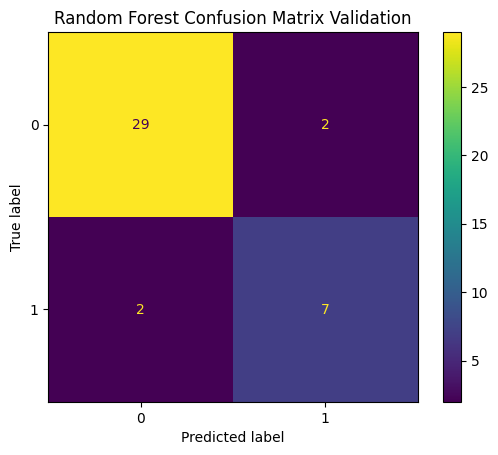

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.78      0.78      0.78         9

    accuracy                           0.90        40
   macro avg       0.86      0.86      0.86        40
weighted avg       0.90      0.90      0.90        40

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 0.25, 'max_leaf_nodes': None, 'max_samples': 0.95, 'min_impurity_decrease': 0.15, 'min_weight_fraction_leaf': 0.005}
out of bag score:  0.7782608695652173


In [51]:
grid_cv_params_entropy = {
    'criterion':['entropy'],
    'max_depth': [5, 10],
    'min_weight_fraction_leaf': [0.005, 0.01, 0.05], # weights sum = 230
    'min_impurity_decrease': [0.15],
    'max_features': ['sqrt', 'log2', 0.5, 0.25],
    'max_samples': [0.85, 0.9, 0.95],
    'max_leaf_nodes': [None],
}

grid_cv_res_entropy = grid_search_cv(rfc_params, grid_cv_params_entropy)
print(grid_cv_res_entropy.best_params_)
print("out of bag score: ",grid_cv_res_entropy.best_estimator_.oob_score_)

### Grid Search for `log_loss` criterion function

Fitting 7 folds for each of 72 candidates, totalling 504 fits
_______________________________
Mean accuracy (Training): 0.8347826086956521
Mean balanced accuracy(Training):  0.8135353915662651
Mean roc auc(Training):  0.9320406626506024


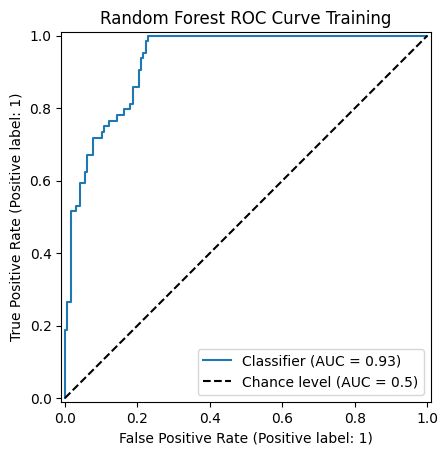

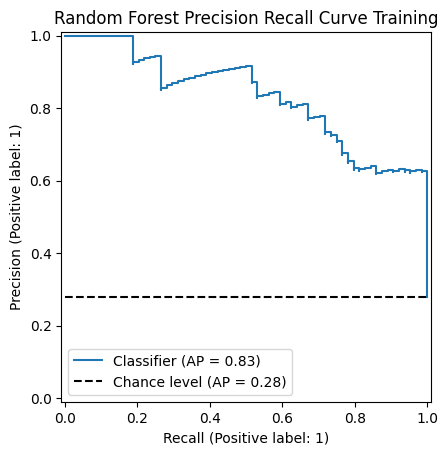

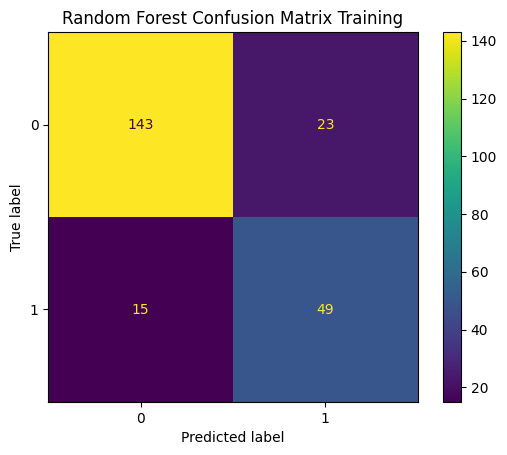

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       166
           1       0.68      0.77      0.72        64

    accuracy                           0.83       230
   macro avg       0.79      0.81      0.80       230
weighted avg       0.84      0.83      0.84       230

Mean accuracy (Validation): 0.9
Mean balanced accuracy(Validation):  0.8566308243727598
Mean roc auc(Validation):  0.9175627240143368


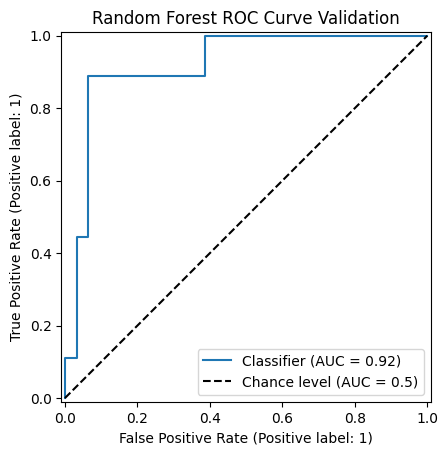

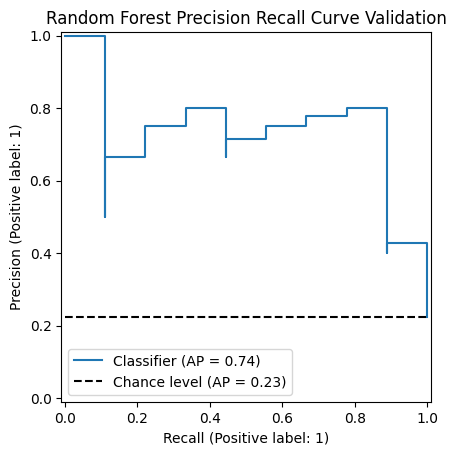

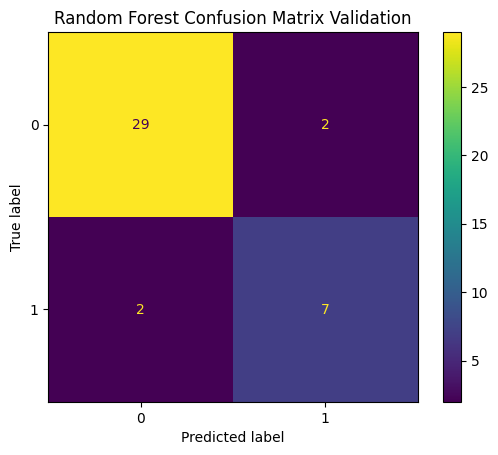

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.78      0.78      0.78         9

    accuracy                           0.90        40
   macro avg       0.86      0.86      0.86        40
weighted avg       0.90      0.90      0.90        40

{'criterion': 'log_loss', 'max_depth': 5, 'max_features': 0.25, 'max_leaf_nodes': None, 'max_samples': 0.95, 'min_impurity_decrease': 0.15, 'min_weight_fraction_leaf': 0.005}
out of bag score:  0.7782608695652173


In [53]:
grid_cv_params_log_los = {
    'criterion':['log_loss'],
    'max_depth': [5, 10],
    'min_weight_fraction_leaf': [0.005, 0.01, 0.05], # weights sum = 230
    'min_impurity_decrease': [0.15],
    'max_features': ['sqrt', 'log2', 0.5, 0.25],
    'max_samples': [0.85, 0.9, 0.95],
    'max_leaf_nodes': [None],

}

grid_cv_res_log_loss = grid_search_cv(rfc_params, grid_cv_params_log_los)
print(grid_cv_res_log_loss.best_params_)
print("out of bag score: ",grid_cv_res_log_loss.best_estimator_.oob_score_)

### Additional checking of parameters from criterion `entropy` and `log_loss` for models with more trees

Fitting 7 folds for each of 24 candidates, totalling 168 fits
_______________________________
Mean accuracy (Training): 0.808695652173913
Mean balanced accuracy(Training):  0.7810617469879518
Mean roc auc(Training):  0.9056852409638554


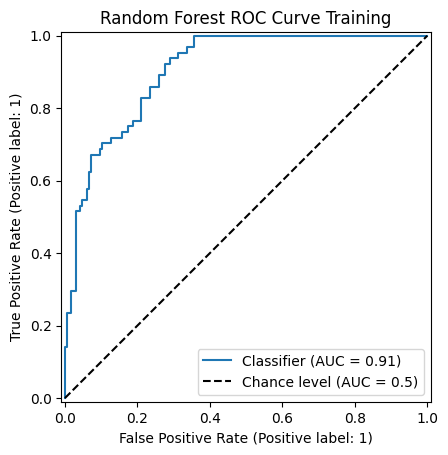

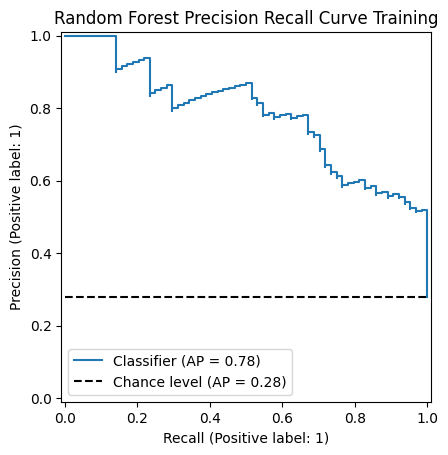

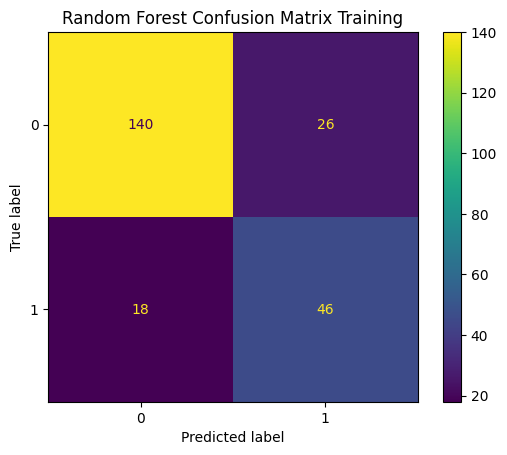

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       166
           1       0.64      0.72      0.68        64

    accuracy                           0.81       230
   macro avg       0.76      0.78      0.77       230
weighted avg       0.82      0.81      0.81       230

Mean accuracy (Validation): 0.9
Mean balanced accuracy(Validation):  0.8566308243727598
Mean roc auc(Validation):  0.9139784946236558


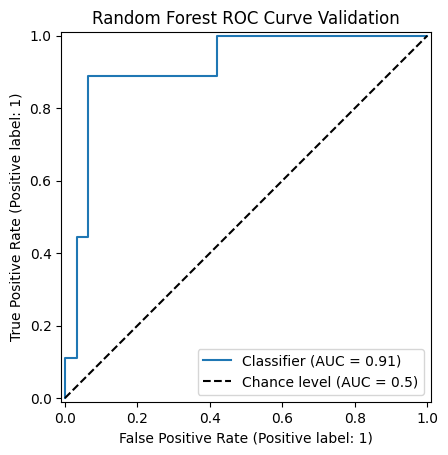

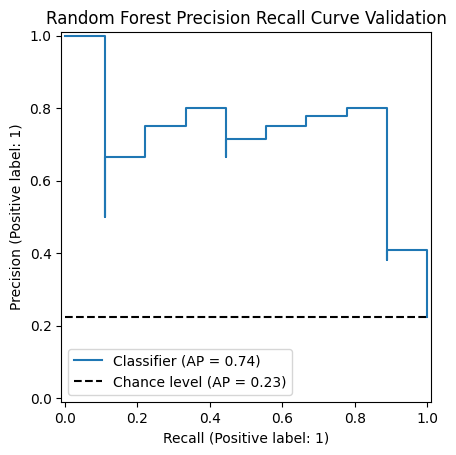

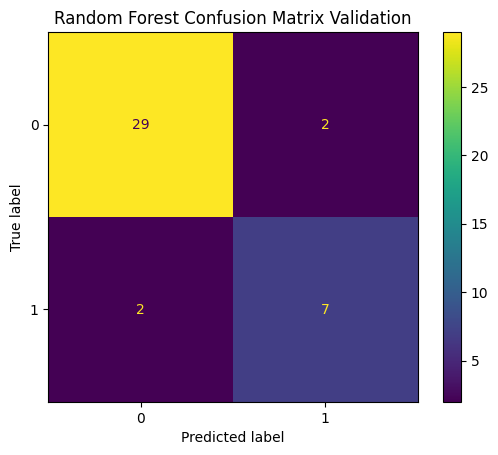

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.78      0.78      0.78         9

    accuracy                           0.90        40
   macro avg       0.86      0.86      0.86        40
weighted avg       0.90      0.90      0.90        40


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 0.25,
 'max_leaf_nodes': None,
 'max_samples': 0.95,
 'min_impurity_decrease': 0.3,
 'min_weight_fraction_leaf': 0.001}

In [54]:
rfc_params_2 = {
    'n_estimators': 10000,
    'bootstrap': True,
    'random_state': rng,
    'class_weight': 'balanced',
    'oob_score': True
}


grid_cv_params = {
    'criterion':['entropy', 'log_loss'],
    'max_depth': [5],
    'min_weight_fraction_leaf': [0.001, 0.005], # weights sum = 230
    'min_impurity_decrease': [0.15, 0.2, 0.3],
    'max_features': [0.25],
    'max_samples': [None, 0.95],
    'max_leaf_nodes': [None],
}

grid_cv_res = grid_search_cv(rfc_params_2, grid_cv_params)
grid_cv_res.best_params_

The best result has the model with `entropy` as criterion function. 
It will be used as a chosen model, but with greater number of `max_features` to improve it.


## Chosen model

Grid Search CV for choosing `max_features`

Fitting 7 folds for each of 4 candidates, totalling 28 fits
_______________________________
Mean accuracy (Training): 0.8478260869565217
Mean balanced accuracy(Training):  0.8273719879518072
Mean roc auc(Training):  0.9361822289156627


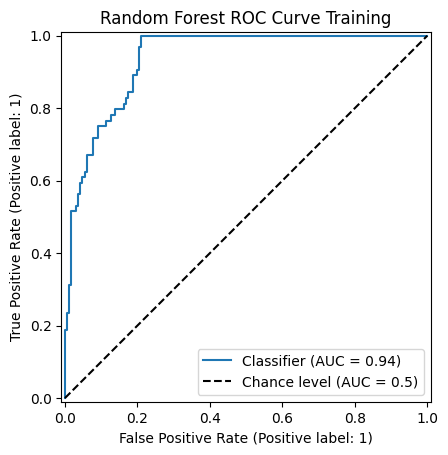

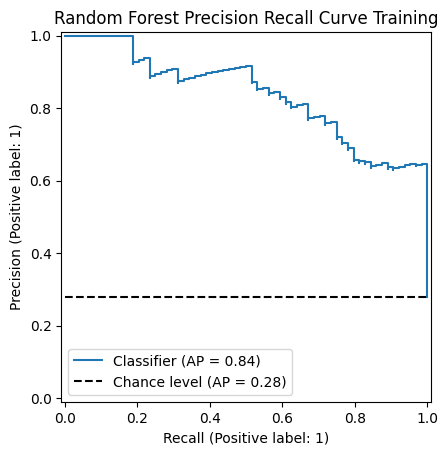

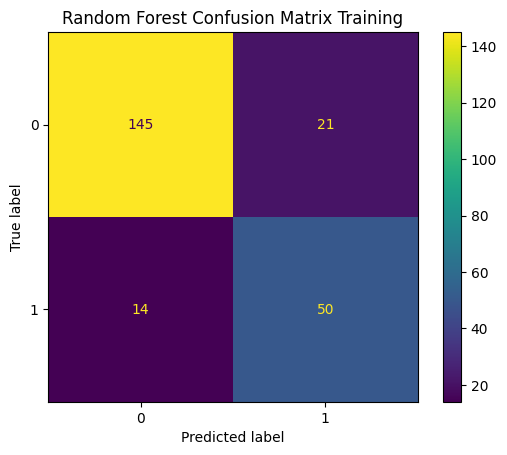

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       166
           1       0.70      0.78      0.74        64

    accuracy                           0.85       230
   macro avg       0.81      0.83      0.82       230
weighted avg       0.85      0.85      0.85       230

Mean accuracy (Validation): 0.9
Mean balanced accuracy(Validation):  0.8566308243727598
Mean roc auc(Validation):  0.921146953405018


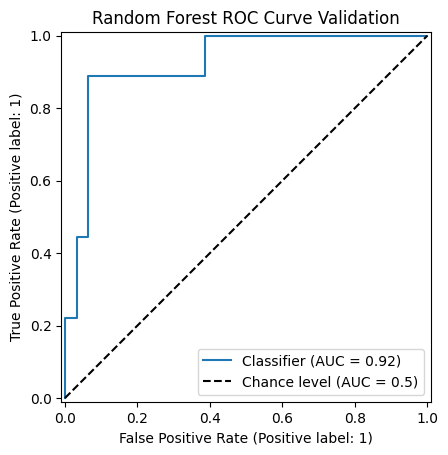

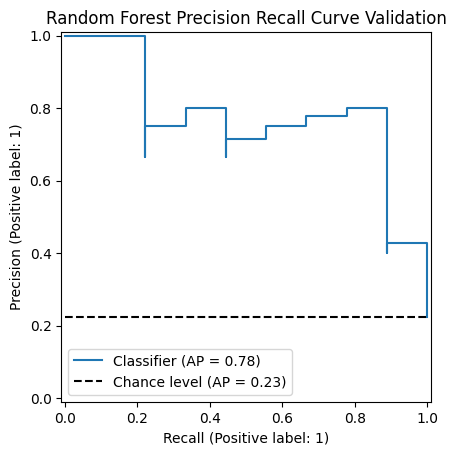

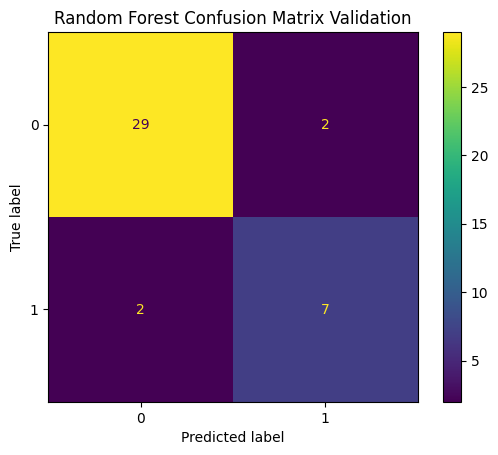

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.78      0.78      0.78         9

    accuracy                           0.90        40
   macro avg       0.86      0.86      0.86        40
weighted avg       0.90      0.90      0.90        40


In [24]:
chosen_model_params = {
    'criterion': ['entropy'], 
    'max_depth': [5], 
    'max_features': [0.25, 0.3, 0.4, 0.5], 
    'max_leaf_nodes':[ None], 
    'max_samples': [0.95], 
    'min_impurity_decrease': [0.15], 'min_weight_fraction_leaf': [0.005]}
chosen_model_check = grid_search_cv(rfc_params, chosen_model_params)

In [25]:
chosen_model_check.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 0.3,
 'max_leaf_nodes': None,
 'max_samples': 0.95,
 'min_impurity_decrease': 0.15,
 'min_weight_fraction_leaf': 0.005}

In [26]:
chosen_model = chosen_model_check.best_estimator_

Save the chosen model

In [27]:
joblib.dump(chosen_model, os.path.join(os.pardir, 'models', 'rfc_model.joblib'))

['..\\models\\rfc_model.joblib']

## Check test results
Download the model if is not defined

In [31]:
if 'chosen_model' in globals():
    chosen_model=joblib.load(os.path.join(os.pardir, 'models', 'rfc_model.joblib'), 'r')

Define a test function

In [33]:
def rfc_classifier_test(rfc, X_test, y_test) -> None:
    y_test_pred = rfc.predict(X_test)
    y_test_pred_proba = rfc.predict_proba(X_test)[:,1]
    classifier_results("RF", "Independent Testing", y_test, y_test_pred, y_test_pred_proba)

Load the test data

In [32]:
store = pd.HDFStore(os.path.join(os.pardir, 'data', 'ctc_split_datasets.h5'), mode='r')

X_test, y_test = store["X_test"], store["y_test"]

store.close()
del store

Check results on test data

Mean accuracy (Independent Testing): 0.8108108108108109
Mean balanced accuracy(Independent Testing):  0.7887931034482758
Mean roc auc(Independent Testing):  0.875


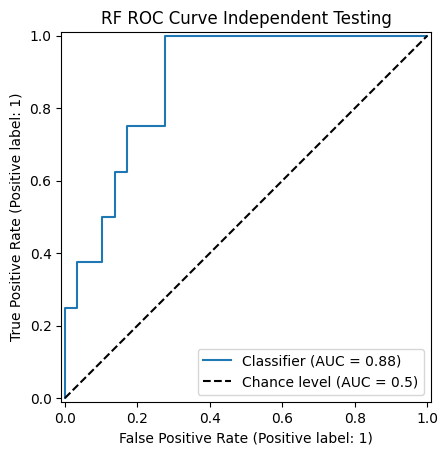

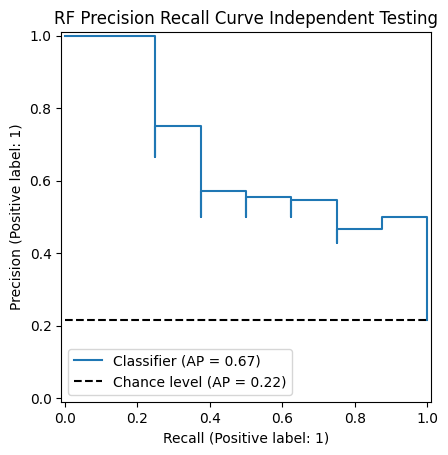

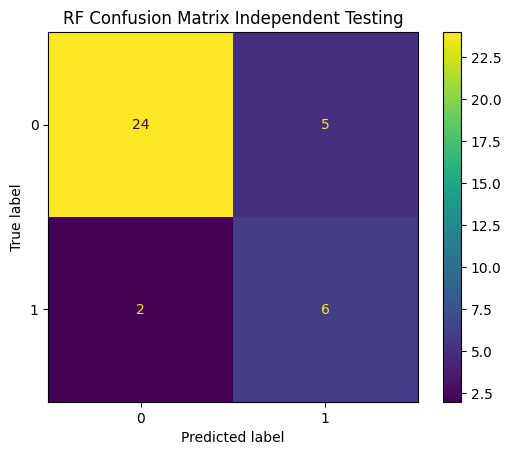

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        29
           1       0.55      0.75      0.63         8

    accuracy                           0.81        37
   macro avg       0.73      0.79      0.75        37
weighted avg       0.84      0.81      0.82        37


In [34]:
rfc_classifier_test(chosen_model, X_test, y_test)

## Significant Features
Get the features (genes) ids

In [5]:
features_names = X_train.columns.tolist()
features_names[:5]

['ENSG00000223972.5',
 'ENSG00000227232.5',
 'ENSG00000278267.1',
 'ENSG00000243485.5',
 'ENSG00000237613.2']

Define and run a function that returns the descending sorted indexes by importance and their values

In [28]:
def sorted_feature_importance(rfc, col_indexes, chosen_features:dict[str, str]=None):
    features_importance_sorted = pd.DataFrame(rfc.feature_importances_, index=col_indexes, columns=["importance"]).sort_values("importance", ascending=False)
    if chosen_features:
        chosen_features = {key: features_importance_sorted.loc[var, 'importance'] for key, var in chosen_features.items()}
        return pd.Series(chosen_features).rename("Importance").sort_values(ascending=False)
    return features_importance_sorted

In [29]:
features_importance = sorted_feature_importance(chosen_model, features_names)
features_importance

,importance
ENSG00000272398.5,0.084869
ENSG00000160209.18,0.051016
ENSG00000196586.13,0.034580
ENSG00000102145.13,0.029885
ENSG00000174175.16,0.029608
...,...
ENSG00000146247.13,0.000000
ENSG00000217512.1,0.000000
ENSG00000118418.14,0.000000
ENSG00000270362.1,0.000000


Save the results to a file

In [30]:
features_importance.to_csv(os.path.join(os.pardir, 'data', 'features_importance.tsv'), sep='\t')